In [8]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00
            Count
Month            
2014-10-01    NaN
2023-08-01    NaN


In [12]:
# ## 2. SARIMA Forecasting for All Wards

import warnings

# warnings.filterwarnings("ignore")

# Set manual orders for all wards
UNIVERSAL_ORDER = (3, 1, 1)
SEASONAL_ORDER = (3, 1, 1, 12)  # Monthly seasonality
TEST_MONTHS = 26

def analyze_ward(args):
    """Process a single ward with SARIMAX"""
    ward_code, ward_df = args
    try:
        # Prepare dataframe
        ward_df = ward_df[['Month', 'Count']].set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df.isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has insufficient data")
            print(ward_df)
            return None

        # Split data
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]

        # Fit SARIMAX model
        model = SARIMAX(train,
                       order=UNIVERSAL_ORDER,
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=TEST_MONTHS).predicted_mean

        # Calculate residuals
        residuals = test['Count'].values - preds.values

        print(f"{ward_code} completed")
        return {
            'ward_code': ward_code,
            'train_size': len(train),
            'test_size': len(test),
            'residuals': residuals,
            'predicted': preds.values,
            'actual': test['Count'].values,
            'model_summary': results.summary()
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# # Prepare arguments for multiprocessing
# args_list = [(code, group.copy())
#             for code, group in burglary_monthly.groupby('Ward Code')]
#
# # Process wards in parallel
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     results = pool.map(analyze_ward, args_list)
#
# # Filter successful results
# results = [res for res in results if res is not None]
# print(f"\nSuccessfully processed {len(results)} wards")

# Process all wards
results = []
# i = 0
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    analysis = analyze_ward((ward_code, group))
    if analysis:
        results.append(analysis)
    #     i += 1
    # if i > 3:
    #     break   # just to test a few wards, not all

# Remove None results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

# warnings.filterwarnings("default")

E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 has more than 20 NaN values, aborted
E05009327 completed
E05009328 has NaN values
E05009328 has more than 20 NaN values, aborted
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 c

Global MAE: 3.24
Global RMSE: 4.31
Mean Residual: 0.60
Positive Residuals: 54.9%


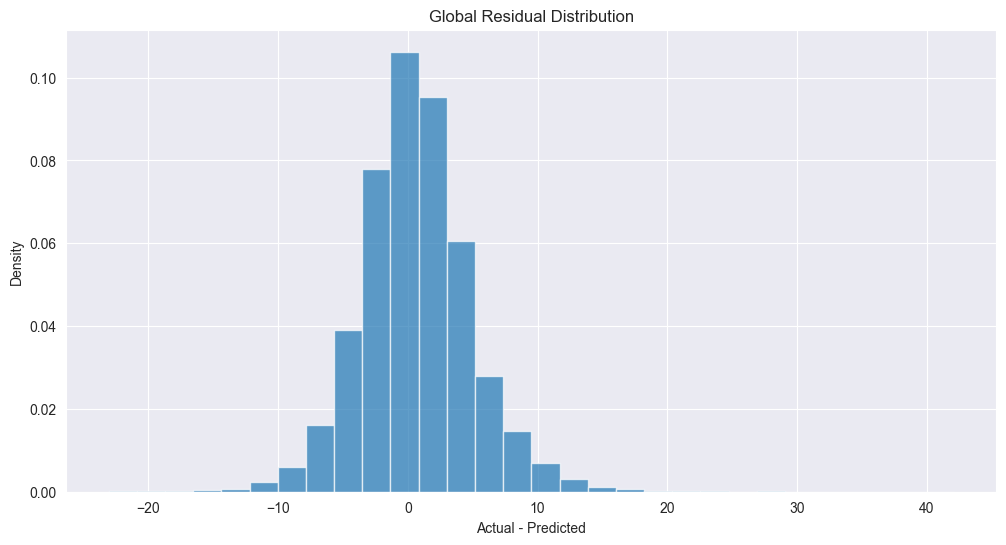

In [13]:
# Combine all residuals
all_residuals = np.concatenate([res['residuals'] for res in results])
all_predicted = np.concatenate([res['predicted'] for res in results])
all_actual = np.concatenate([res['actual'] for res in results])

# Overall metrics
print(f"Global MAE: {mean_absolute_error(all_actual, all_predicted):.2f}")
print(f"Global RMSE: {np.sqrt(mean_squared_error(all_actual, all_predicted)):.2f}")
print(f"Mean Residual: {np.mean(all_residuals):.2f}")
print(f"Positive Residuals: {np.mean(all_residuals > 0)*100:.1f}%")

# Residual distribution plot
plt.figure(figsize=(12, 6))
plt.hist(all_residuals, bins=30, density=True, alpha=0.7)
plt.title('Global Residual Distribution')
plt.xlabel('Actual - Predicted')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
def plot_ward_diagnostics(result):
    """Visualize model performance for a single ward"""
    plt.figure(figsize=(15, 10))

    # Time series plot
    plt.subplot(2, 1, 1)
    plt.plot(result['predicted'], 'r--', label='Predictions')
    plt.plot(result['actual'], 'k-', label='Actual')
    plt.title(f"Ward {result['ward_code']} - Forecast vs Actual")
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)

    # Residual plot
    plt.subplot(2, 1, 2)
    plt.stem(result['residuals'], basefmt=' ')
    plt.title('Residuals')
    plt.xlabel('Time Step')
    plt.ylabel('Residual')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Generate diagnostics for first 5 wards
for res in results[:1]:
    plot_ward_diagnostics(res)
    print(f"\nWard {res['ward_code']} Metrics:")
    print(f"MAE: {mean_absolute_error(res['actual'], res['predicted']):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(res['actual'], res['predicted'])):.2f}")
    print(f"Avg Residual: {np.mean(res['residuals']):.2f}\n")

In [ ]:
# Collect ward-level metrics
metrics = []
for res in results:
    metrics.append({
        'ward': res['ward_code'],
        'mae': mean_absolute_error(res['actual'], res['predicted']),
        'rmse': np.sqrt(mean_squared_error(res['actual'], res['predicted'])),
        'mean_residual': np.mean(res['residuals']),
        'residual_std': np.std(res['residuals'])
    })

metrics_df = pd.DataFrame(metrics)

# Print summary statistics
print("\nModel Performance Summary:")
print(f"Average Ward MAE: {metrics_df['mae'].mean():.2f}")
print(f"Average Ward RMSE: {metrics_df['rmse'].mean():.2f}")
print(f"Wards with Positive Bias: {(metrics_df['mean_residual'] > 0).sum()}")
print(f"Wards with Negative Bias: {(metrics_df['mean_residual'] < 0).sum()}")

In [46]:
# Load and process car ownership data
cars_df = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars_df['NoCarPct'] = (cars_df['none'] / cars_df['All households'])
cars = cars_df[['ward code', 'NoCarPct']].rename(columns={'ward code': 'ward_code'})

# Merge with SARIMA results
results_df = pd.DataFrame(results)

hybrid_data = pd.merge(results_df, cars, on='ward_code', how='inner')

occupancy_df = pd.read_excel('data/housing/occupancy_rating_bedrooms_wards.xlsx', sheet_name='2021')
occupancy_df["ZeroRoomPct"] = (occupancy_df["0"] / occupancy_df["All Households"])
occupancy = occupancy_df[["ward code", "ZeroRoomPct"]].rename(columns={'ward code': 'ward_code'})

results_df = pd.DataFrame(occupancy)

hybrid_data = pd.merge(hybrid_data, occupancy, on='ward_code', how='inner')


print(f"Wards with both SARIMA and socio-economic data: {len(hybrid_data)}")

hybrid_data

Wards with both SARIMA and socio-economic data: 631


,ward_code,train_size,test_size,residuals,predicted,actual,model_summary,NoCarPct,ZeroRoomPct
0,E05009317,109,26,"[14.115730671965501, 2.6927054178632783, 6.846...","[11.884269328034499, 7.307294582136722, 15.153...","[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...",SARIMAX R...,0.632145,0.484684
1,E05009318,109,26,"[-5.7710286386774765, -3.4090759025227033, -3....","[9.771028638677477, 7.409075902522703, 11.3074...","[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...",SARIMAX R...,0.691681,0.577126
2,E05009319,109,26,"[15.993722776604496, 9.14743669980367, 15.8926...","[10.006277223395504, 2.85256330019633, 7.10738...","[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...",SARIMAX R...,0.650541,0.540274
3,E05009320,109,26,"[9.137884298756887, 4.096822809740164, 2.54571...","[3.8621157012431135, 4.903177190259836, 8.4542...","[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...",SARIMAX R...,0.577921,0.444402
4,E05009321,109,26,"[1.7154439585559462, 10.81464396039964, 4.9363...","[6.284556041444054, 2.1853560396003617, 4.0636...","[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...",SARIMAX R...,0.640424,0.532069
...,...,...,...,...,...,...,...,...,...
626,E05014115,109,26,"[0.869182241246973, 5.307639322828033, 13.9718...","[7.130817758753027, 5.692360677171967, 6.02819...","[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...",SARIMAX R...,0.525633,0.447277
627,E05014116,109,26,"[-3.503310517186935, -0.43273331681198446, 0.7...","[4.503310517186935, 2.4327333168119845, 3.2599...","[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...",SARIMAX R...,0.497338,0.424015
628,E05014117,109,26,"[-3.5782390427859436, -0.8701160895287359, 1.0...","[6.578239042785944, 2.870116089528736, 3.96006...","[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...",SARIMAX R...,0.747097,0.562408
629,E05014118,109,26,"[0.7893051155407669, 4.503186172777967, 7.6380...","[9.210694884459233, 5.496813827222033, 5.36191...","[10, 10, 13, 11, 9, 9, 8, 8, 9, 5, 5, 6, 7, 12...",SARIMAX R...,0.726968,0.547262


0      4.266214
1      2.642043
2      7.656145
3      3.943164
4      3.538208
         ...   
626    3.766235
627    2.227110
628    2.904172
629    4.654284
630    2.201444
Name: residuals, Length: 631, dtype: float64
PearsonRResult(statistic=-0.09100174344297762, pvalue=0.022245462962164144)
SignificanceResult(statistic=-0.11677160262086739, pvalue=0.0033086136102322855)
SignificanceResult(statistic=-0.08096495861947528, pvalue=0.002347888991165653)


PearsonRResult(statistic=0.3474250195763765, pvalue=2.438763020812911e-19)
SignificanceResult(statistic=0.3353034736332295, pvalue=4.805026794195995e-18)
SignificanceResult(statistic=0.2304580786355747, pvalue=4.736703245006497e-18)



PearsonRResult(statistic=-0.12592513827034443, pvalue=0.0015267165641949206)
SignificanceResult(statistic=-0.15263510086174534, pvalue=0.0001185411658192315)
SignificanceResult(statistic=-0.104812215430282, pvalue=8.204232289620333e-05)


PearsonRResult(statistic=0.3093030301751286, pvalue=1.86572502758

<function matplotlib.pyplot.show(close=None, block=None)>

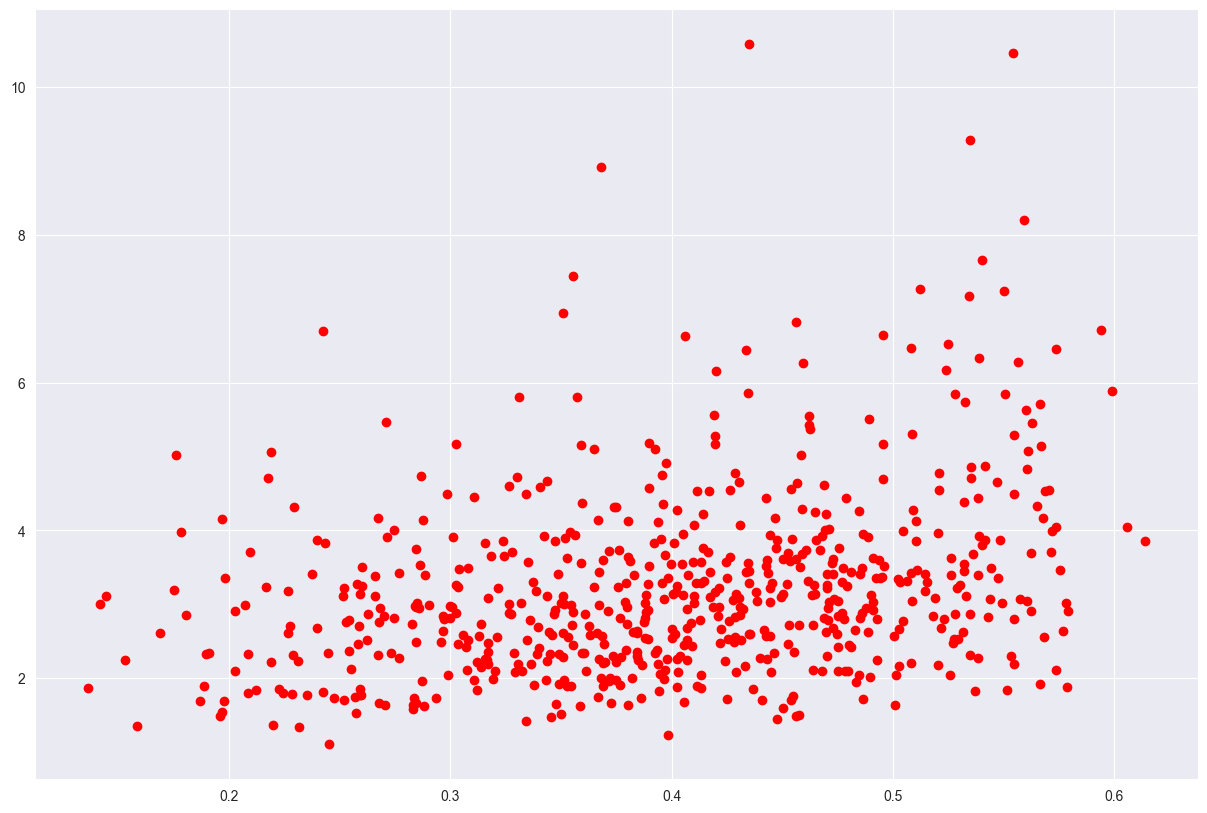

In [50]:
from scipy.stats import pearsonr, spearmanr, kendalltau

mean_residuals = hybrid_data["residuals"].apply(lambda x: np.mean(x))
abs_mean_residuals = hybrid_data["residuals"].apply(lambda x: np.mean(np.abs(x)))
print(abs_mean_residuals)
no_car_pct = hybrid_data["NoCarPct"]
zero_room_pct = hybrid_data["ZeroRoomPct"]

print(pearsonr(no_car_pct, mean_residuals))
print(spearmanr(no_car_pct, mean_residuals))
print(kendalltau(no_car_pct, mean_residuals))
print("\n")
print(pearsonr(no_car_pct, abs_mean_residuals))
print(spearmanr(no_car_pct, abs_mean_residuals))
print(kendalltau(no_car_pct, abs_mean_residuals))

print("\n\n")

print(pearsonr(zero_room_pct, mean_residuals))
print(spearmanr(zero_room_pct, mean_residuals))
print(kendalltau(zero_room_pct, mean_residuals))
print("\n")
print(pearsonr(zero_room_pct, abs_mean_residuals))
print(spearmanr(zero_room_pct, abs_mean_residuals))
print(kendalltau(zero_room_pct, abs_mean_residuals))

plt.figure(figsize=(15, 10))
plt.scatter(zero_room_pct, abs_mean_residuals, c='r', label='NoCarPct')
plt.show

In [7]:
from sklearn.linear_model import LinearRegression


def calculate_adjustment_target(ward_data):
    """Calculate optimal adjustment target using residual patterns"""
    # Calculate normalized residuals
    avg_crimes = ward_data['actual'].mean()
    residuals = ward_data['residuals']

    # Option 1: Residual trend slope
    # slope = LinearRegression().fit(np.arange(len(residuals)).reshape(-1,1), residuals).coef_[0]

    # Option 2: Weighted average residual (recent residuals weighted more)
    weights = np.linspace(0.5, 1.5, len(residuals))
    weighted_avg = np.average(residuals, weights=weights)

    # Option 3: Residual RMSE contribution
    rmse_contribution = np.sqrt(np.mean(residuals**2))

    # Combine metrics
    return {
        'ward_code': ward_data['ward_code'],
        'adj_target': weighted_avg * 0.7 + rmse_contribution * 0.3,
        'norm_adj_target': (weighted_avg * 0.7 + rmse_contribution * 0.3) / avg_crimes
    }

# Calculate targets for all wards
targets = [calculate_adjustment_target(row) for _, row in hybrid_data.iterrows()]
target_df = pd.DataFrame(targets)

# Merge with main data
hybrid_data = pd.merge(hybrid_data, target_df, on='ward_code').rename(columns={'adj_target_x': 'adj_target', 'norm_adj_target_x': 'norm_adj_target'})

hybrid_data

,ward_code,train_size,test_size,residuals,predicted,actual,model_summary,NoCarPct,adj_target,norm_adj_target
0,E05009317,109,26,"[14.115730671965501, 2.6927054178632783, 6.846...","[11.884269328034499, 7.307294582136722, 15.153...","[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...",SARIMAX R...,0.632145,2.305455,0.168376
1,E05009318,109,26,"[-5.7710286386774765, -3.4090759025227033, -3....","[9.771028638677477, 7.409075902522703, 11.3074...","[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...",SARIMAX R...,0.691681,0.133562,0.018086
2,E05009319,109,26,"[15.993722776604496, 9.14743669980367, 15.8926...","[10.006277223395504, 2.85256330019633, 7.10738...","[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...",SARIMAX R...,0.650541,7.258515,0.521330
3,E05009320,109,26,"[9.137884298756887, 4.096822809740164, 2.54571...","[3.8621157012431135, 4.903177190259836, 8.4542...","[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...",SARIMAX R...,0.577921,3.539641,0.436164
4,E05009321,109,26,"[1.7154439585559462, 10.81464396039964, 4.9363...","[6.284556041444054, 2.1853560396003617, 4.0636...","[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...",SARIMAX R...,0.640424,2.762344,0.401234
...,...,...,...,...,...,...,...,...,...,...
673,E05014115,109,26,"[0.869182241246973, 5.307639322828033, 13.9718...","[7.130817758753027, 5.692360677171967, 6.02819...","[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...",SARIMAX R...,0.525633,1.753040,0.214995
674,E05014116,109,26,"[-3.503310517186935, -0.43273331681198446, 0.7...","[4.503310517186935, 2.4327333168119845, 3.2599...","[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...",SARIMAX R...,0.497338,1.935527,0.670983
675,E05014117,109,26,"[-3.5782390427859436, -0.8701160895287359, 1.0...","[6.578239042785944, 2.870116089528736, 3.96006...","[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...",SARIMAX R...,0.747097,2.447070,0.395179
676,E05014118,109,26,"[0.7893051155407669, 4.503186172777967, 7.6380...","[9.210694884459233, 5.496813827222033, 5.36191...","[10, 10, 13, 11, 9, 9, 8, 8, 9, 5, 5, 6, 7, 12...",SARIMAX R...,0.726968,4.584760,0.502969


In [8]:

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Prepare data
X = hybrid_data[['NoCarPct']]
y = hybrid_data['norm_adj_target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
adj_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
adj_model.fit(X_train, y_train)

# Evaluate
train_score = adj_model.score(X_train, y_train)
test_score = adj_model.score(X_test, y_test)
print(f"Adjustment model R² - Train: {train_score:.3f}, Test: {test_score:.3f}")

Adjustment model R² - Train: 0.268, Test: 0.044


In [10]:
def hybrid_predict(ward_data, adj_model):
    """Generate hybrid predictions"""
    # Base SARIMA predictions
    sarima_pred = ward_data['predicted']

    # Get socio-economic features
    socio_features = [ward_data['NoCarPct']]

    # Predict adjustment
    adj_factor = adj_model.predict([socio_features])[0]

    # Scale adjustment by ward's crime level
    avg_crimes = ward_data['actual'].mean()
    adjustment = adj_factor * avg_crimes

    # Apply directional adjustment
    base_residual_sign = np.sign(ward_data['residuals'].mean())
    hybrid_pred = sarima_pred + (adjustment * base_residual_sign)

    return hybrid_pred

# Generate hybrid predictions
hybrid_results = []
for _, row in hybrid_data.iterrows():
    try:
        hybrid_pred = hybrid_predict(row, adj_model)
        hybrid_results.append({
            'ward_code': row['ward_code'],
            'actual': row['actual'],
            'sarima_pred': row['predicted'],
            'hybrid_pred': hybrid_pred,
            'adjustment': hybrid_pred - row['predicted']
        })
    except:
        continue

# Calculate metrics
metrics = []
for result in hybrid_results:
    metrics.append({
        'ward': result['ward_code'],
        'sarima_mae': mean_absolute_error(result['actual'], result['sarima_pred']),
        'hybrid_mae': mean_absolute_error(result['actual'], result['hybrid_pred']),
        'sarima_rmse': np.sqrt(mean_squared_error(result['actual'], result['sarima_pred'])),
        'hybrid_rmse': np.sqrt(mean_squared_error(result['actual'], result['hybrid_pred'])),
        'avg_adjustment': np.mean(result['adjustment'])
    })

metrics_df = pd.DataFrame(metrics)

# Overall improvement
print(f"MAE Improvement: {metrics_df['sarima_mae'].mean() - metrics_df['hybrid_mae'].mean():.2f}")
print(f"RMSE Improvement: {metrics_df['sarima_rmse'].mean() - metrics_df['hybrid_rmse'].mean():.2f}")

def plot_hybrid_comparison(result):
    """Plot SARIMA vs Hybrid predictions"""
    plt.figure(figsize=(12, 6))

    plt.plot(result['actual'], 'ko-', label='Actual')
    plt.plot(result['sarima_pred'], 'b--', label='SARIMA')
    plt.plot(result['hybrid_pred'], 'r-.', label='Hybrid')

    plt.title(f"Prediction Comparison - Ward {result['ward_code']}")
    plt.xlabel('Time Steps')
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot relationships
plt.figure(figsize=(12, 5))
plt.scatter(hybrid_data['NoCarPct'], hybrid_data['norm_adj_target'], alpha=0.5)
plt.xlabel('Percentage of Households with No Car')
plt.ylabel('Normalized Adjustment Target')
plt.title('Socio-Economic Factor vs Required Adjustment')
plt.grid(True)
plt.show()

# Plot sample predictions
for res in hybrid_results[:3]:
    plot_hybrid_comparison(res)

MAE Improvement: 0.31
RMSE Improvement: 0.37


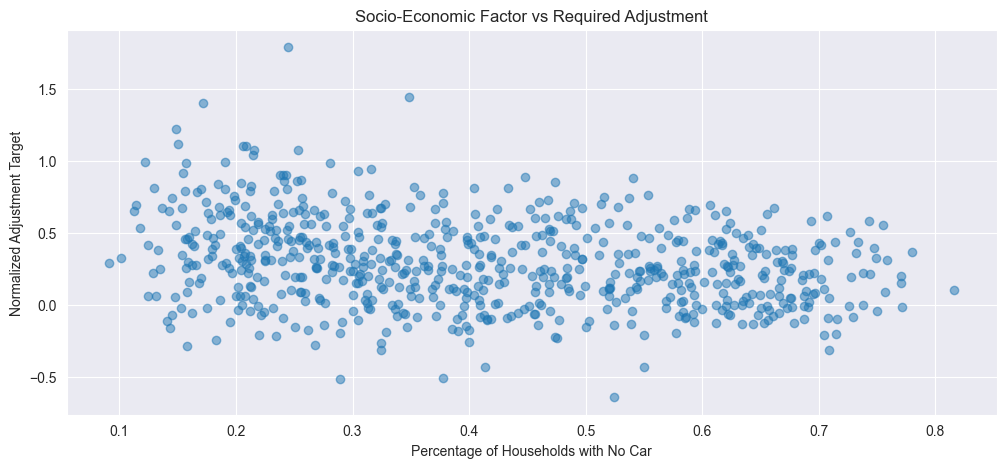

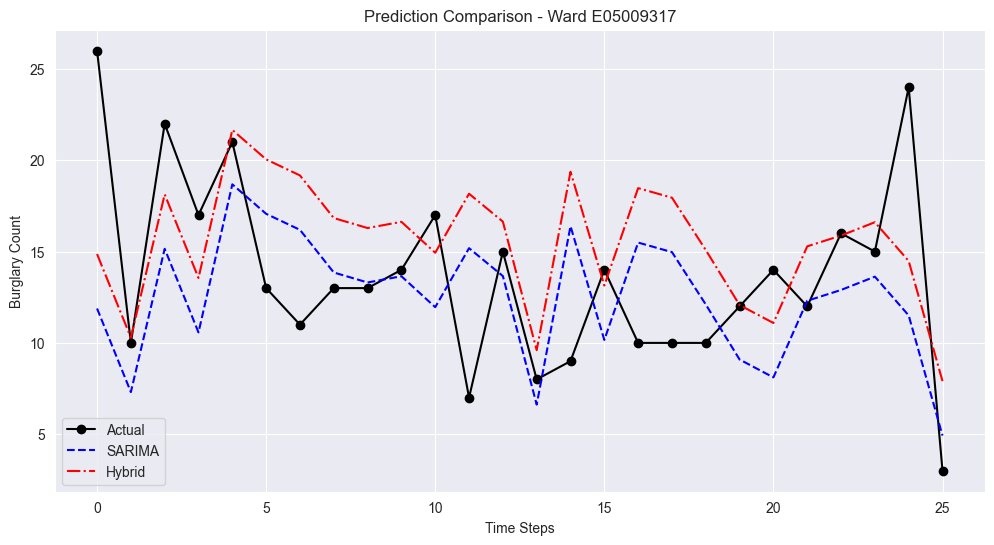

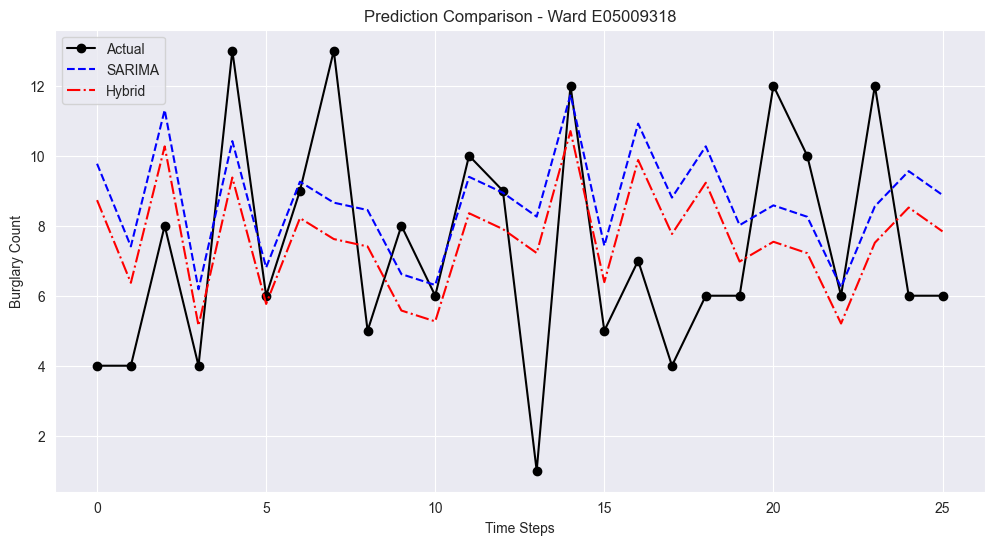

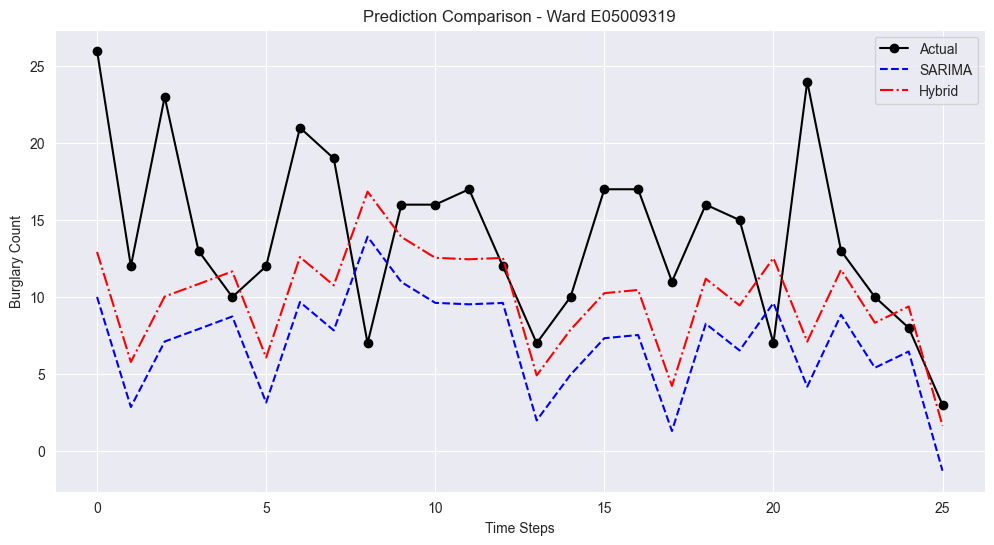